In [ ]:
pip install fuzzywuzzy

In [ ]:
pip install python-Levenshtein

In [ ]:
pip install -U prettytable

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
pip install wordcloud

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import numpy as np
import nltk

from numpy.random import choice
from itertools import chain
from random import choice
from prettytable import PrettyTable
from fuzzywuzzy import process
from wordcloud import WordCloud, STOPWORDS

from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics.pairwise import cosine_similarity

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.classify.scikitlearn import SklearnClassifier

## Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
# Step 0: Getting the Data

# Read the CSV file into a DataFrame
file_path = 'netflix_titles.csv' # Netflix Database file
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to inspect the data
#print(df.head())

# Extract 'category' and 'description' columns
selected_columns = ['description', 'category']
netflix_data = df[selected_columns]

# A PrettyTable for the selected columns
table = PrettyTable(['description', 'category'])
# Set the maximum width for each column
table.max_width['description'] = 60
table.max_width['category'] = 60
for index, row in netflix_data.head().iterrows():
    table.add_row([row['description'], row['category']])
    table.add_row(['-' * 60, '-' * 60])

print('=' * 55 + ' Netflix Data!!! '+ '=' * 55)
print(table)
print('*' * 127)

======================================================= Netflix Data!!! =======================================================
+--------------------------------------------------------------+--------------------------------------------------------------+
|                         description                          |                           category                           |
+--------------------------------------------------------------+--------------------------------------------------------------+
|  As her father nears the end of his life, filmmaker Kirsten  |                        Documentaries                         |
|  Johnson stages his death in inventive and comical ways to   |                                                              |
|             help them both face the inevitable.              |                                                              |
| ------------------------------------------------------------ | ---------------------------------------

In [3]:
# Step 1: Data Preprocessing

In [4]:
# 1.01: Check for missing data and fill it in if needed

# Check for missing data
missing_data = netflix_data.isnull().sum()
print("Missing Data:\n", missing_data)

# Fill missing data based on data type
for column in netflix_data.columns:
    if missing_data[column] > 0:
        if netflix_data[column].dtype == 'object':
            # For object (string) data type, fill missing values with the most frequent value
            netflix_data[column].fillna(netflix_data[column].mode()[0], inplace=True)
            
            # Check if missing data is filled 
            missing_data_after_fill = netflix_data.isnull().sum()
            print("\nMissing Data after filling:\n", missing_data_after_fill)
            
        elif netflix_data[column].dtype in ['int64', 'float64']:
            # For numeric data types, fill missing values with the mean
            netflix_data[column].fillna(netflix_data[column].mean(), inplace=True)
            # Check if missing data is filled 
            missing_data_after_fill = netflix_data.isnull().sum()
            print("\nMissing Data after filling:\n", missing_data_after_fill)

Missing Data:
 description    0
category       0
dtype: int64


In [5]:
# 1.02: Check for duplicates and remove them if needed

# Check for all duplicates
duplicates = netflix_data.duplicated().sum()
print("\nNumber of Duplicates:", duplicates)

# Check for duplicates in each column
for column in netflix_data.columns:
    print(f"\nNumber of Duplicates in {column} column: {netflix_data[column].duplicated().sum()}")

# Get the indices of duplicate rows in the 'description' column
duplicate_indices_description = netflix_data[netflix_data.duplicated(subset=['description'], keep=False)]
#print("\nIndices of Duplicate Rows in 'description' column:", duplicate_indices_description)

# Removes duplicate rows based on the 'description' column, keeping the first occurrence.
netflix_data.drop_duplicates(subset=['description'], keep='first', inplace=True)

# Check for duplicates again 
duplicates = netflix_data.duplicated().sum()
print("\nNumber of Duplicates:", duplicates)


Number of Duplicates: 30

Number of Duplicates in description column: 32

Number of Duplicates in category column: 8293

Number of Duplicates: 0


In [6]:
# 1.03: Check if the features need to be standardized or unified and adjust them if needed

# Functions Needed for the previous step and used afterward 

# a function to count lists
def count_values(col):
    empty_count = 0
    one_value_count = 0 
    two_values_count = 0
    three_values_count = 0
    for item in col:
        if len(item) == 0: empty_count += 1
        elif len(item) == 1: one_value_count +=1
        elif len(item) == 2: two_values_count +=1
        elif len(item) == 3: three_values_count +=1
    count = [empty_count, one_value_count, two_values_count, three_values_count]     
    return count

# Function to make label column values unified based on a list of unified labels
def find_all_matches(label, target_labels, score_nu):
    matches = process.extract(label, target_labels)
    filtered_matches = [(match, score) for match, score in matches if score >= score_nu]  # Adjust the threshold as needed
    return [match for match, _ in filtered_matches]

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def find_all_matches2(labels, target_labels, threshold=0.5):
    # Convert the string of labels into a list
    labels = labels.split(', ')
    
    # Initialize TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    
    # Fit transform target labels
    target_vectors = vectorizer.fit_transform(target_labels)
    
    # Transform input labels
    input_vectors = vectorizer.transform(labels)
    
    # Calculate cosine similarity between input labels and target labels
    similarities = cosine_similarity(input_vectors, target_vectors)
    
    # Filter matches based on threshold
    matching_labels = []
    for similarity_row in similarities:
        matches = [target_labels[j] for j, score in enumerate(similarity_row) if score >= threshold]
        matching_labels.append(matches)    
    return list(set(chain.from_iterable(matching_labels)))

# Function to map a label column based on a dictionary of labels 
def map_labels(column, labels_mapping):
    final_labels = []
    for label, mapped_labels in labels_mapping.items():
        if any(value in column for value in mapped_labels):
            final_labels.append(label)
    return final_labels

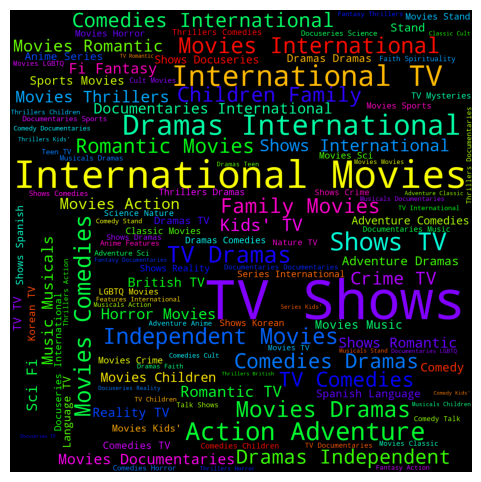

+--------------------------------------------------+-------+
|                     Category                     | Count |
+--------------------------------------------------+-------+
|           Dramas, International Movies           |  362  |
|                  Documentaries                   |  359  |
|                 Stand-Up Comedy                  |  334  |
|      Comedies, Dramas, International Movies      |  273  |
| Dramas, Independent Movies, International Movies |  252  |
|                     Kids' TV                     |  218  |
|             Children & Family Movies             |  215  |
|        Children & Family Movies, Comedies        |  200  |
|       Documentaries, International Movies        |  186  |
|  Dramas, International Movies, Romantic Movies   |  179  |
+--------------------------------------------------+-------+


In [7]:
# 1.03.0: Visualise the Data

# Use WordCloud to show the data
text = ' '.join(netflix_data['category'])
plt.rcParams['figure.figsize'] = (6,6)
wordcloud = WordCloud(background_color = 'black',colormap='gist_rainbow', width = 1200,  height = 1200, max_words = 121).generate(text)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# A PrettyTable for the Unique Categories and Corresponding Count 
table = PrettyTable(['Category', 'Count'])
for category, count in netflix_data['category'].value_counts().items():
    table.add_row([category, count])
# Print the first few rows of the table
print(table.get_string(start=0, end=10))

In [8]:
# 1.03.1: Make the categories unified

# List of unified labels
unified_categories = [
    'Comedy', 'Comedies', 'Stand-Up Comedy', 'Action', 'Horror', 'Drama', 'Sci-Fi & Fantasy', 'Thriller', 
    'Thrillers', 'Western', 'Mystery', 'Mysteries', 'Adventure', 'Science & Nature', 'Crime', 'Animation', 
    'Anime', 'Docuseries', 'Documentary', 'Documentaries', 'Faith & Spirituality', 'Romance', 'Romantic', 
    'Romancy', 'History', 'Historical', 'Sport', 'Sports', 'International', 'Family', 'Families', 'Kid', 'Kids', 
    'Reality', 'Children', 'Classic', 'Cult', 'British', 'Teen', 'Independent', 'LGBTQ', 'Spanish', 'Stand-Up', 
    'Talk Show', 'Talk Shows', 'Korean', 'Dramas', 'Music', 'Musical', 'Movies', 'TV Shows'
]

# Apply the function to create a new 'unified_categories' column
netflix_data['unified_categories'] = netflix_data['category'].apply(lambda x: find_all_matches2(x, unified_categories))

# A PrettyTable for 3 columns
table = PrettyTable(['description', 'category', 'unified_categories'])
table.max_width['description'] = 40
table.max_width['category'] = 40
table.max_width['unified_categories'] = 40
for index, row in netflix_data.head().iterrows():
    table.add_row([row['description'], row['category'], str(row['unified_categories'])])
    table.add_row(['-' * 40, '-' * 40, '-' * 40])

print('=' * 55 + ' Netflix Data!!! '+ '=' * 55)
print(table)
print('*' * 127)

print("Missing Data in unified_categories column:", count_values(netflix_data['unified_categories'])[0])

if count_values(netflix_data['unified_categories'])[0] != 0: 
    # Filter the DataFrame to get rows with empty lists in the 'unified_categories' column
    empty_lists_rows = netflix_data[netflix_data['unified_categories'].apply(lambda x: len(x) == 0)]

    # Check where the matching fails
    table = PrettyTable(['Category', 'Count'])
    for category, count in empty_lists_rows['category'].value_counts().items():
        table.add_row([category, count])
    print('=' * 55 + ' Matching fails!!! '+ '=' * 55)
    # Print the first few rows of the table 
    print(table.get_string(start=0, end=10))
    print('*' * 127)

# A PrettyTable for the Unique unified Categories and Corresponding Count 
table = PrettyTable(['Category', 'Count'])
for category, count in netflix_data['unified_categories'].value_counts().items():
    table.add_row([category, count])
print('=' * 55 + ' Unified Categories!!! '+ '=' * 55)
# Print the first few rows of the table
print(table.get_string(start=0, end=10))
print('*' * 127)

======================================================= Netflix Data!!! =======================================================
+------------------------------------------+------------------------------------------+------------------------------------------+
|               description                |                 category                 |            unified_categories            |
+------------------------------------------+------------------------------------------+------------------------------------------+
| As her father nears the end of his life, |              Documentaries               |            ['Documentaries']             |
|   filmmaker Kirsten Johnson stages his   |                                          |                                          |
|  death in inventive and comical ways to  |                                          |                                          |
|   help them both face the inevitable.    |                                          

In [9]:
# 1.03.2: Convert the unified categories to the final categories

# Dictionary of labels 
final_categories_mapping = {
    'Unknown': ['Movies', 'TV Shows'],
    'Documentary': ['Documentary', 'Docuseries', 'Documentaries'],
    'Comedy': ['Comedy', 'Stand-Up Comedy', 'Comedies', 'Stand-Up'],
    'Sci-Fi & Fantasy': ['Sci-Fi & Fantasy'],
    'Musical': ['Music', 'Dramas', 'Musical'],
    'Faith & Spirituality': ['Faith & Spirituality'],
    'Family': ['Family', 'Families'],
    'Children': ['Children', 'Kids', 'Kid'],
    'Anime': ['Animation', 'Anime'],
    'International': ['International'],
    'Crime': ['Crime'],
    'Action': ['Action'],
    'Horror': ['Horror'], 
    'Drama': ['Drama'], 
    'Romance': ['Romance', 'Romantic', 'Romancy'],
    'Thriller': ['Thriller', 'Thrillers'], 
    'Western': ['Western'], 
    'Mystery': ['Mystery', 'Mysteries'], 
    'Adventure': ['Adventure'],
    'History': ['Historical', 'History'],
    'Sport': ['Sport', 'Sport'],
    'Reality': ['Reality'],
    'Classic': ['Classic'],
    'Cult': ['Cult'], 
    'British': ['British'],
    'Teen': ['Teen'], 
    'Independent': ['Independent'],
    'LGBTQ': ['LGBTQ'],
    'Spanish': ['Spanish'], 
    'Korean': ['Korean']
}

# Apply the function to create a new final_categories column
netflix_data['final_categories'] = netflix_data['unified_categories'].apply(lambda x: map_labels(x, final_categories_mapping))

# A PrettyTable after categories matching & mapping
table = PrettyTable(['category', 'unified_categories', 'final_categories'])
# Set the maximum width for each column
table.max_width['category'] = 40
table.max_width['unified_categories'] = 40
table.max_width['final_categories'] = 40
for index, row in netflix_data.iterrows():
    table.add_row([row['category'], str(row['unified_categories']), str(row['final_categories'])])
    table.add_row(['-' * 40, '-' * 40, '-' * 40])

print('=' * 55 + ' Matching & Mapping!!! '+ '=' * 55)
#print(table)
print(table.get_string(start=0, end=10))
print('*' * 127)

print("Missing Data in final_categories column:", count_values(netflix_data['final_categories'])[0])

# Check for failure
if count_values(netflix_data['final_categories'])[0] != 0: 
    # Filter the DataFrame to get rows with empty lists in the 'final_categories' column
    empty_lists_rows = netflix_data[netflix_data['final_categories'].apply(lambda x: len(x) == 0)]

    # Show the failure 
    # A PrettyTable after categories matching & mapping 
    table = PrettyTable(['category', 'unified_categories', 'final_categories'])
    # Set the maximum width for each column
    table.max_width['category'] = 40
    table.max_width['unified_categories'] = 40
    table.max_width['final_categories'] = 40

    for index, row in empty_lists_rows.iterrows():
        table.add_row([row['category'], str(row['unified_categories']), str(row['final_categories'])])
        table.add_row(['-' * 40, '-' * 40, '-' * 40])

    print('=' * 55 + ' The Failure!!! '+ '=' * 55)
    print(table.get_string(start=0, end=10))
    print('*' * 127)

# A PrettyTable for the Unique final Categories and Corresponding Count 
table = PrettyTable(['Category', 'Count'])
for category, count in netflix_data['final_categories'].value_counts().items():
    table.add_row([category, count])
print('=' * 55 + ' Final Categories!!! '+ '=' * 55)
# Print the first few rows of the table
print(table.get_string(start=0, end=10))
print('*' * 127)

======================================================= Matching & Mapping!!! =======================================================
+------------------------------------------+------------------------------------------+------------------------------------------+
|                 category                 |            unified_categories            |             final_categories             |
+------------------------------------------+------------------------------------------+------------------------------------------+
|              Documentaries               |            ['Documentaries']             |             ['Documentary']              |
| ---------------------------------------- | ---------------------------------------- | ---------------------------------------- |
|  International TV Shows, TV Dramas, TV   |   ['TV Shows', 'Dramas', 'Mysteries',    | ['Unknown', 'Musical', 'International',  |
|                Mysteries                 |             'International']       

In [10]:
# 1.03.3: Convert the final categories to short categories
short_categories_mapping = {
    'Documentary': ['Documentary', 'Docuseries', 'Documentaries'],
    'Comedy': ['Comedy', 'Stand-Up Comedy', 'Comedies', 'Stand-Up'],
    'Sci-Fi & Fantasy': ['Sci-Fi & Fantasy'],
    'Musical': ['Music', 'Dramas', 'Musical'],
    'Faith & Spirituality': ['Faith & Spirituality'],
    'Family & Children': ['Family', 'Families', 'Children', 'Kids', 'Kid'],
    'Anime': ['Animation', 'Anime'],
    'Action & Adventure': ['Action', 'Adventure'],
    'Crime & Horror & Mystery': ['Horror', 'Crime', 'Mystery', 'Mysteries'], 
    'Drama & Thriller': ['Drama', 'Thriller', 'Thrillers'], 
    'Romance': ['Romance', 'Romantic', 'Romancy'],
    'History': ['Historical', 'History'],
    'Sport': ['Sport', 'Sport'],
    'Reality': ['Reality'],
    'Teen': ['Teen', 'LGBTQ'],
    'International': ['International']
}

# Apply the function to create a new short_categories column
netflix_data['short_categories'] = netflix_data['final_categories'].apply(lambda x: map_labels(x, short_categories_mapping))

# A PrettyTable after categories matching & mapping & shortening
table = PrettyTable(['category', 'unified_categories', 'final_categories', 'short_categories'])
# Set the maximum width for each column
table.max_width['category'] = 30
table.max_width['unified_categories'] = 30
table.max_width['final_categories'] = 30
table.max_width['short_categories'] = 30

for index, row in netflix_data.iterrows():
    table.add_row([row['category'], str(row['unified_categories']), str(row['final_categories']), str(row['short_categories'])])
    table.add_row(['-' * 30, '-' * 30, '-' * 30, '-' * 30])

print('=' * 55 + ' Categories!!! '+ '=' * 55)
#print(table)
print(table.get_string(start=0, end=10))
print('*' * 127)

print("Missing Data in short_categories column:", count_values(netflix_data['short_categories'])[0])

# Check for failure 
if count_values(netflix_data['short_categories'])[0] != 0: 
    # Filter the DataFrame to get rows with empty lists in the 'short_categories' column
    empty_lists_rows = netflix_data[netflix_data['short_categories'].apply(lambda x: len(x) == 0)]
    
    # Show the failure 
    # A PrettyTable after categories matching & mapping & shortening
    table = PrettyTable(['category', 'unified_categories', 'final_categories', 'short_categories'])
    # Set the maximum width for each column
    table.max_width['category'] = 30
    table.max_width['unified_categories'] = 30
    table.max_width['final_categories'] = 30
    table.max_width['short_categories'] = 30

    for index, row in empty_lists_rows.iterrows():
        table.add_row([row['category'], str(row['unified_categories']), str(row['final_categories']), str(row['short_categories'])])
        table.add_row(['-' * 30, '-' * 30, '-' * 30, '-' * 30])

    print('=' * 55 + ' The Failure!!! '+ '=' * 55)
    print(table.get_string(start=0, end=10))
    print('*' * 127)

# Iterate over DataFrame rows
for index, item in netflix_data['short_categories'].items(): 
    # Check if the list is empty
    if len(item) == 0: 
        # Fill the empty list with a randomly chosen value from non-empty lists
        netflix_data.at[index, 'short_categories'] = [choice(netflix_data['short_categories'].explode().dropna().unique().tolist())]

# Check for missing data after filling
print("Missing Data in short_categories column:", count_values(netflix_data['short_categories'])[0])

======================================================= Categories!!! =======================================================
+--------------------------------+--------------------------------+--------------------------------+--------------------------------+
|            category            |       unified_categories       |        final_categories        |        short_categories        |
+--------------------------------+--------------------------------+--------------------------------+--------------------------------+
|         Documentaries          |       ['Documentaries']        |        ['Documentary']         |        ['Documentary']         |
| ------------------------------ | ------------------------------ | ------------------------------ | ------------------------------ |
|   International TV Shows, TV   |     ['TV Shows', 'Dramas',     |     ['Unknown', 'Musical',     | ['Musical', 'Crime & Horror &  |
|      Dramas, TV Mysteries      | 'Mysteries', 'International']  |  '

In [11]:
# Option 1: keep the data and train a multi-target classifier

# Step 3: Data preparation & Splitting
X_train, X_test, Y_train, Y_test = train_test_split(netflix_data['description'], netflix_data['short_categories'], test_size=0.2, random_state=42)

# Convert final_categories to binary matrix
mlb = MultiLabelBinarizer()
Y_train_bin = mlb.fit_transform(Y_train)
Y_test_bin = mlb.transform(Y_test)

# Step 4: Feature extraction
# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Step 5: Model Selection and Training

# Multinomial Naive Bayes
nb = MultinomialNB()  
multi_target_classifier_nb = MultiOutputClassifier(nb)
multi_target_classifier_nb.fit(X_train_tfidf, Y_train_bin)
# RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)
multi_target_classifier_rf = MultiOutputClassifier(rf)
multi_target_classifier_rf.fit(X_train_tfidf, Y_train_bin)

# Step 6: Model Evaluation
print("Multinomial Naive Bayes Accuracy:", accuracy_score(Y_test_bin, multi_target_classifier_nb.predict(X_test_tfidf)))
print("Random Forest Accuracy:", accuracy_score(Y_test_bin, multi_target_classifier_rf.predict(X_test_tfidf)))

Multinomial Naive Bayes Accuracy: 0.12991452991452992
Random Forest Accuracy: 0.1641025641025641


In [12]:
# Option 2: change the data to be a single label for each description

In [13]:
# Option 2.01: for each description randomly choose from the short_categories list

# Step 2: Prepare the Data for training & Testing
train_test_data1 = pd.DataFrame(columns=['description', 'category'])
train_test_data1['description'] = netflix_data['description']
#train_test_data['category'] = netflix_data['short_categories'].apply(lambda x: ', '.join(x))
train_test_data1['category'] = netflix_data['short_categories'].apply(lambda x: choice(x))

# A PrettyTable for train_test_data
table = PrettyTable(['description', 'category'])
# Set the maximum width for each column
table.max_width['description'] = 80
table.max_width['category'] = 40
for index, row in train_test_data1.iterrows():
    table.add_row([row['description'], row['category']])
    table.add_row(['-' * 80, '-' * 40])

print('=' * 55 + ' Training & Testing Data!!! '+ '=' * 55)
print(table.get_string(start=0, end=20))
print('*' * 127)

# Step 3: Data preparation & Splitting

# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to the 'category' column
train_test_data1['category_code'] = le.fit_transform(train_test_data1['category'].astype(str))

# Data preperation & Splitting
x_train, x_test, y_train, y_test = train_test_split(train_test_data1['description'], train_test_data1['category_code'], test_size=0.2, random_state=42)

# Step 4: Feature extraction

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Using count Vectorizer
vectorizer = CountVectorizer()
x_train_count = vectorizer.fit_transform(x_train)
x_test_count = vectorizer.transform(x_test)

# Step 5: Model Selection and Training

# Train the RandomForestClassifier model with TF-IDF Vectorizer
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=0)
rf_tfidf.fit(x_train_tfidf, y_train)
# Train the RandomForestClassifier model with count Vectorizer
rf_count = RandomForestClassifier(n_estimators=100, random_state=0)
rf_count.fit(x_train_count, y_train)

# Multinomial Naive Bayes model with TF-IDF Vectorizer
nb_tfidf = MultinomialNB()
nb_tfidf.fit(x_train_tfidf, y_train)
# Multinomial Naive Bayes model with count Vectorizer
nb_count = MultinomialNB()
nb_count.fit(x_train_count, y_train)

# Step 6: Model Evaluation

# Test the RandomForestClassifier model 
print(f"Accuracy of the RandomForestClassifier & TF-IDF Vectorizer: {accuracy_score(y_test, rf_tfidf.predict(x_test_tfidf))}")
print(f"Accuracy of the RandomForestClassifier & count Vectorizer: {accuracy_score(y_test, rf_count.predict(x_test_count))}")

# Test the Multinomial Naive Bayes model 
print(f"Accuracy of the Multinomial Naive Bayes & TF-IDF Vectorizer: {accuracy_score(y_test, nb_tfidf.predict(x_test_tfidf))}")
print(f"Accuracy of the Multinomial Naive Bayes & count Vectorizer: {accuracy_score(y_test, nb_count.predict(x_test_count))}")

======================================================= Training & Testing Data!!! =======================================================
+----------------------------------------------------------------------------------+------------------------------------------+
|                                   description                                    |                 category                 |
+----------------------------------------------------------------------------------+------------------------------------------+
|  As her father nears the end of his life, filmmaker Kirsten Johnson stages his   |               Documentary                |
|    death in inventive and comical ways to help them both face the inevitable.    |                                          |
| -------------------------------------------------------------------------------- | ---------------------------------------- |
|  After crossing paths at a party, a Cape Town teen sets out to prove whether a   |         

In [14]:
# Option 2.02: for each description choose the 1st item from the short_categories list

# Step 2: Prepare the Data for training & Testing
train_test_data2 = pd.DataFrame(columns=['description', 'category'])
train_test_data2['description'] = netflix_data['description']
train_test_data2['category'] = netflix_data['short_categories'].apply(lambda x: x[0])

# A PrettyTable for train_test_data
table = PrettyTable(['description', 'category'])
# Set the maximum width for each column
table.max_width['description'] = 80
table.max_width['category'] = 40
for index, row in train_test_data2.iterrows():
    table.add_row([row['description'], row['category']])
    table.add_row(['-' * 80, '-' * 40])

print('=' * 55 + ' Training & Testing Data!!! '+ '=' * 55)
print(table.get_string(start=0, end=20))
print('*' * 127)

# Step 3: Data preparation & Splitting

# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to the 'category' column
train_test_data2['category_code'] = le.fit_transform(train_test_data2['category'].astype(str))

# Data preperation & Splitting
x_train, x_test, y_train, y_test = train_test_split(train_test_data2['description'], train_test_data2['category_code'], test_size=0.2, random_state=42)

# Step 4: Feature extraction

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Using count Vectorizer
vectorizer = CountVectorizer()
x_train_count = vectorizer.fit_transform(x_train)
x_test_count = vectorizer.transform(x_test)

# Step 5: Model Selection and Training

# Train the RandomForestClassifier model with TF-IDF Vectorizer
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=0)
rf_tfidf.fit(x_train_tfidf, y_train)
# Train the RandomForestClassifier model with count Vectorizer
rf_count = RandomForestClassifier(n_estimators=100, random_state=0)
rf_count.fit(x_train_count, y_train)

# Multinomial Naive Bayes model with TF-IDF Vectorizer
nb_tfidf = MultinomialNB()
nb_tfidf.fit(x_train_tfidf, y_train)
# Multinomial Naive Bayes model with count Vectorizer
nb_count = MultinomialNB()
nb_count.fit(x_train_count, y_train)

# Step 6: Model Evaluation

# Test the RandomForestClassifier model 
print(f"Accuracy of the RandomForestClassifier & TF-IDF Vectorizer: {accuracy_score(y_test, rf_tfidf.predict(x_test_tfidf))}")
print(f"Accuracy of the RandomForestClassifier & count Vectorizer: {accuracy_score(y_test, rf_count.predict(x_test_count))}")

# Test the Multinomial Naive Bayes model 
print(f"Accuracy of the Multinomial Naive Bayes & TF-IDF Vectorizer: {accuracy_score(y_test, nb_tfidf.predict(x_test_tfidf))}")
print(f"Accuracy of the Multinomial Naive Bayes & count Vectorizer: {accuracy_score(y_test, nb_count.predict(x_test_count))}")

======================================================= Training & Testing Data!!! =======================================================
+----------------------------------------------------------------------------------+------------------------------------------+
|                                   description                                    |                 category                 |
+----------------------------------------------------------------------------------+------------------------------------------+
|  As her father nears the end of his life, filmmaker Kirsten Johnson stages his   |               Documentary                |
|    death in inventive and comical ways to help them both face the inevitable.    |                                          |
| -------------------------------------------------------------------------------- | ---------------------------------------- |
|  After crossing paths at a party, a Cape Town teen sets out to prove whether a   |         

In [15]:
# Implement Bag-of-Words NLTK using option 2.02: for each description choose the 1st item from the short_categories list

# Step 3: Data Preparation & Splitting

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_test_data2['description'], train_test_data2['category'], test_size=0.2, random_state=42)

# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the training labels
y_train_encoded = le.fit_transform(y_train)

# Transform the testing labels
y_test_encoded = le.transform(y_test)

# Step 4: Feature extraction

# Preprocess the text data
def preprocess(sentence):
    sentence = sentence.lower()  # Convert the sentences into lowercase
    tokenizer = RegexpTokenizer(r'\w+')  # Tokenize on word characters
    tokens = tokenizer.tokenize(sentence)
    filtered_words = [w for w in tokens if not w in stopwords.words('english')]  # Remove stopwords
    return filtered_words

# Tagging, Assign part of speech (pos) to words. Extract only noun and verb
def extract_tagged(sentences):
    features = []
    for tagged_word in sentences:
        word, tag = tagged_word
        if tag in ['NN', 'NNS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ']:  # Filter only relevant POS tags
            features.append(word)
    return features

# Lemmatize and Stem words in sentence
stemmer = SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

def extract_feature(text):
    words = preprocess(text)
    tags = nltk.pos_tag(words)
    extracted_features = extract_tagged(tags)
    stemmed_words = [stemmer.stem(x) for x in extracted_features]
    result = [lmtzr.lemmatize(x) for x in stemmed_words]
    return result

# Implementing bag of words
def word_feats(words):
    return dict([(word, True) for word in words])

# Extract features from the training and testing data
X_train_feats = [(word_feats(extract_feature(desc)), label) for desc, label in zip(X_train, y_train_encoded)]
X_test_feats = [(word_feats(extract_feature(desc)), label) for desc, label in zip(X_test, y_test_encoded)]

# Step 5: Model Training and Evaluation
# Train the NLTK classifier (Random Forest) using SklearnClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
sklearn_rf_classifier = SklearnClassifier(rf_classifier)
sklearn_rf_classifier.train(X_train_feats)

# Step 6: Evaluate the model
y_pred = [sklearn_rf_classifier.classify(feats) for feats, _ in X_test_feats]
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5236467236467236


In [16]:
# Implement Word2Vec NLTK using option 2.02: for each description choose the 1st item from the short_categories list

# Step 3: Data Preparation & Splitting

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_test_data2['description'], train_test_data2['category'], test_size=0.2, random_state=42)

# Initialize LabelEncoder
le = LabelEncoder()

# Fit and transform the training labels
y_train_encoded = le.fit_transform(y_train)

# Transform the testing labels
y_test_encoded = le.transform(y_test)

# Step 4: Feature extraction

# Preprocess the text data
def preprocess(sentence):
    sentence = sentence.lower()  # Convert the sentences into lowercase
    tokenizer = RegexpTokenizer(r'\w+')  # Tokenize on word characters
    tokens = tokenizer.tokenize(sentence)
    filtered_words = [w for w in tokens if not w in stopwords.words('english')]  # Remove stopwords
    return filtered_words

# Train Word2Vec model on the preprocessed text data
sentences = [preprocess(desc) for desc in X_train]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)


# Step 5: Model Training and Evaluation

# Function to calculate average word vector for a document
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector

# Function to compute average word vectors for all documents in the dataset
def get_average_word_vectors(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    features = [average_word_vectors(words, model, vocabulary, num_features) for words in corpus]
    return np.array(features)

# Convert text data to average Word2Vec vectors
X_train_word2vec = get_average_word_vectors(sentences, word2vec_model, 100)
X_test_word2vec = get_average_word_vectors([preprocess(desc) for desc in X_test], word2vec_model, 100)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_word2vec, y_train_encoded)

# Step 6: Evaluate the model
y_pred = rf_classifier.predict(X_test_word2vec)
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.36182336182336183


In [17]:
# Option 2.03: Allowing multiple descriptions where for each description one value from the short_categories list

# Step 2: Prepare the Data for training & Testing
train_test_data_list = []
for index, row in netflix_data.iterrows():
    description = row['description']
    final_categories = row['final_categories']
        # Duplicate the row for each category in final_categories
    for category in final_categories:
        train_test_data_list.append({'description': description, 'category': category})
train_test_data3 = pd.DataFrame(train_test_data_list)

# A PrettyTable for train_test_data
table = PrettyTable(['description', 'category'])
# Set the maximum width for each column
table.max_width['description'] = 80
table.max_width['category'] = 40
for index, row in train_test_data3.iterrows():
    table.add_row([row['description'], row['category']])
    table.add_row(['-' * 80, '-' * 40])

print('=' * 55 + ' Training & Testing Data!!! '+ '=' * 55)
print(table.get_string(start=0, end=20))
print('*' * 127)

# Step 3: Data preparation & Splitting

# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to the 'category' column
train_test_data3['category_code'] = le.fit_transform(train_test_data3['category'].astype(str))

# Data preperation & Splitting
x_train, x_test, y_train, y_test = train_test_split(train_test_data3['description'], train_test_data3['category_code'], test_size=0.2, random_state=42)

# Step 4: Feature extraction

# Using TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Using count Vectorizer
vectorizer = CountVectorizer()
x_train_count = vectorizer.fit_transform(x_train)
x_test_count = vectorizer.transform(x_test)

# Step 5: Model Selection and Training

# Train the RandomForestClassifier model with TF-IDF Vectorizer
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=0)
rf_tfidf.fit(x_train_tfidf, y_train)
# Train the RandomForestClassifier model with count Vectorizer
rf_count = RandomForestClassifier(n_estimators=100, random_state=0)
rf_count.fit(x_train_count, y_train)

# Multinomial Naive Bayes model with TF-IDF Vectorizer
nb_tfidf = MultinomialNB()
nb_tfidf.fit(x_train_tfidf, y_train)
# Multinomial Naive Bayes model with count Vectorizer
nb_count = MultinomialNB()
nb_count.fit(x_train_count, y_train)

# Step 6: Model Evaluation

# Test the RandomForestClassifier model 
print(f"Accuracy of the RandomForestClassifier & TF-IDF Vectorizer: {accuracy_score(y_test, rf_tfidf.predict(x_test_tfidf))}")
print(f"Accuracy of the RandomForestClassifier & count Vectorizer: {accuracy_score(y_test, rf_count.predict(x_test_count))}")

# Test the Multinomial Naive Bayes model 
print(f"Accuracy of the Multinomial Naive Bayes & TF-IDF Vectorizer: {accuracy_score(y_test, nb_tfidf.predict(x_test_tfidf))}")
print(f"Accuracy of the Multinomial Naive Bayes & count Vectorizer: {accuracy_score(y_test, nb_count.predict(x_test_count))}")

======================================================= Training & Testing Data!!! =======================================================
+----------------------------------------------------------------------------------+------------------------------------------+
|                                   description                                    |                 category                 |
+----------------------------------------------------------------------------------+------------------------------------------+
|  As her father nears the end of his life, filmmaker Kirsten Johnson stages his   |               Documentary                |
|    death in inventive and comical ways to help them both face the inevitable.    |                                          |
| -------------------------------------------------------------------------------- | ---------------------------------------- |
|  After crossing paths at a party, a Cape Town teen sets out to prove whether a   |         

In [ ]:
# Define a function to predict categories for new descriptions

def predict_category(model, vectorizer, encoder, description):
    # Transform the new description into feature vectors
    description_vector = vectorizer.transform([description])
    
    # Predict the probabilities for each category
    probabilities = model.predict_proba(description_vector)
    
    # Predict the category using the trained model
    prediction = model.predict(description_vector)
    
    # Decode the predicted category using the LabelEncoder
    predicted_category = encoder.inverse_transform(prediction)
    
    # Display the probabilities for each label
    labels = encoder.classes_
    for label, probability in zip(labels, probabilities[0]):
        print(f"Probability for {label}: {probability:.4f}")
    
    return predicted_category[0]

# Predict a new description and display the probabilities for each category
new_description = "An exciting sci-fi adventure in outer space"
predicted_category = predict_category(model, vectorizer, encoder, new_description)
print("Predicted category for the new description:", predicted_category)